In [1]:
# Simulation of MRAC control adding voltage bias to controllable VV/VW curves

In [2]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.utils.input_parser import input_parser

In [3]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.controllers.adaptive_inverter_controller import AdaptiveInverterController
from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController
from pycigar.devices.pv_inverter_device import PVDevice

In [4]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', MRAC_adaptive_controller)
register_devcon('custom_pv_device', PVDevice)

'custom_pv_device'

In [5]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'

This is where we change experiment parameters

In [6]:
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=0.1  #control=0.1
misc_inputs.value['k']=0
#misc_inputs.Value['solar scaling factor']=1.5
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

hack=0.20

In [7]:
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'

sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time
sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

All the information of the experiment has been logged in the `logger` of PyCIGAR.
The `logger` has 2 dictionaries:
- `logger().log_dict`: a dictionary has all informations of inverters/nodes.
- `logger().custom_metric`: a dictionary has custom metric (substation power,...) 

In [8]:
from pycigar.utils.logging import logger
Logger = logger()

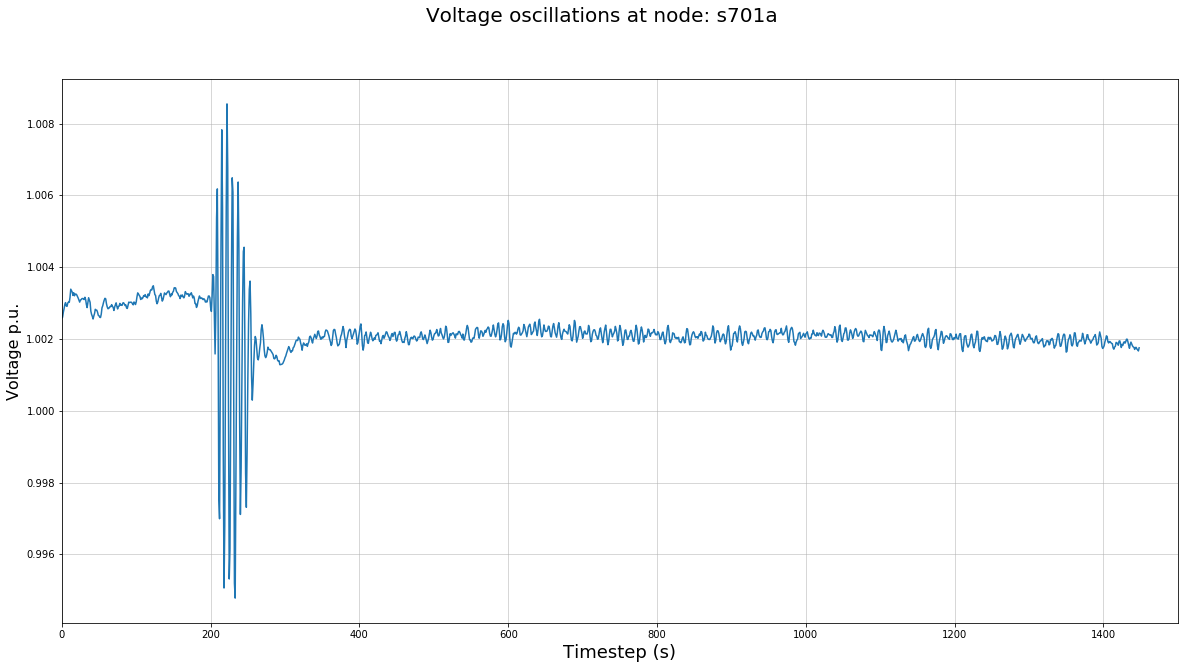

In [9]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.savefig("voltage_bias.png")
plt.show()

In [10]:
node_id = 's701a'
xmax = 600
voltage_csv = np.asarray(Logger.log_dict[node_id]['voltage'][0:xmax]).reshape(-1,1)
time_vec = np.arange(0,xmax).reshape(-1,1)
time_voltages = np.concatenate((time_vec, voltage_csv), axis=1)
df = pd.DataFrame(time_voltages, columns=['Time', 'Voltage'])

#df.to_csv("voltage_bias_voltage" + node_id + "_control.csv")
#df.to_csv("voltage_bias_voltage" + node_id + "_no_control.csv")

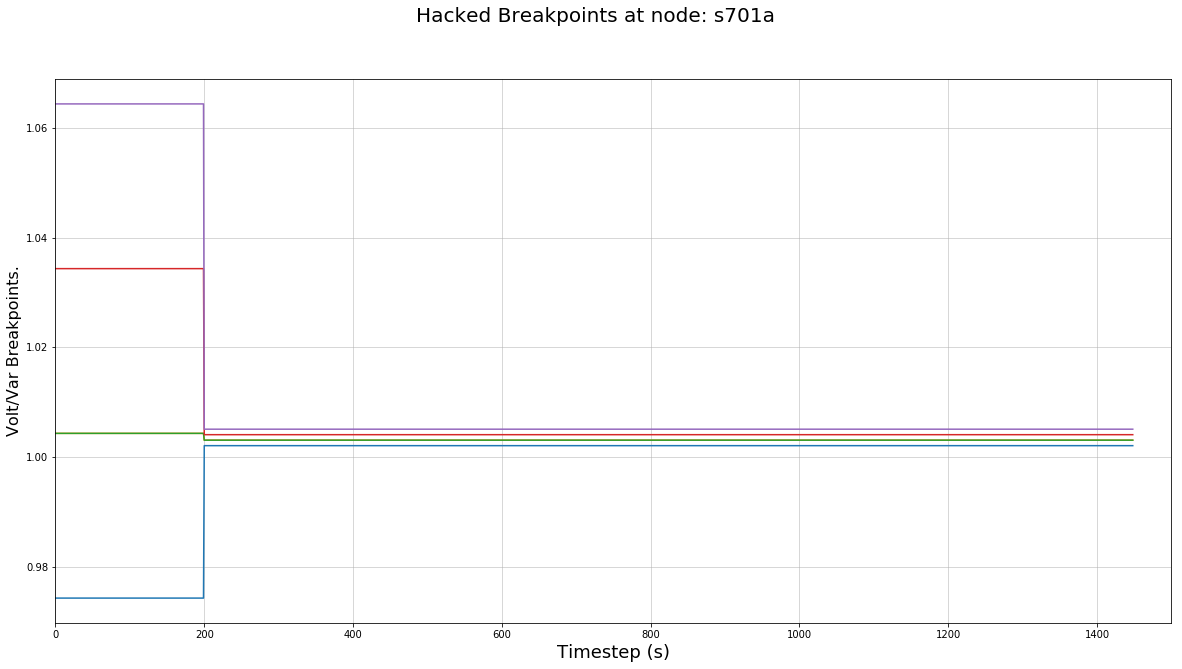

In [11]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'adversary_inverter_s701a'
f.suptitle('Hacked Breakpoints at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Volt/Var Breakpoints.', fontsize=16)
ax.plot(Logger.log_dict[key]['control_setting'])
plt.show()

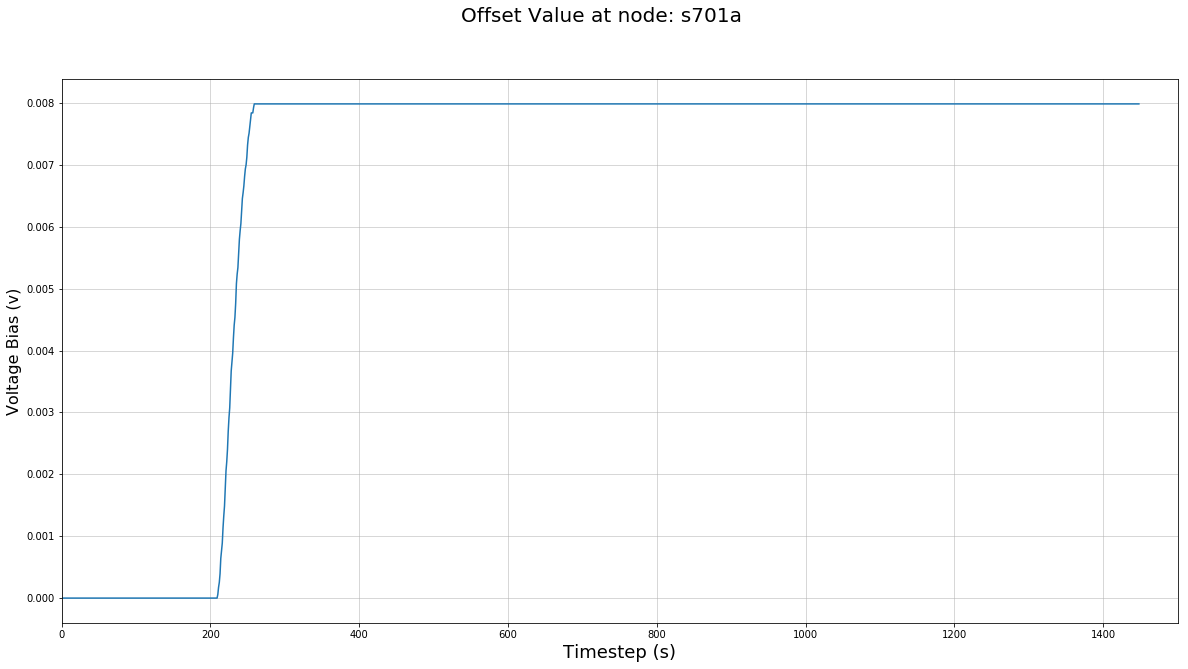

In [12]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'inverter_s701a'
f.suptitle('Offset Value at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage Bias (v)', fontsize=16)
ax.plot(Logger.log_dict[key]['y'])
plt.show()

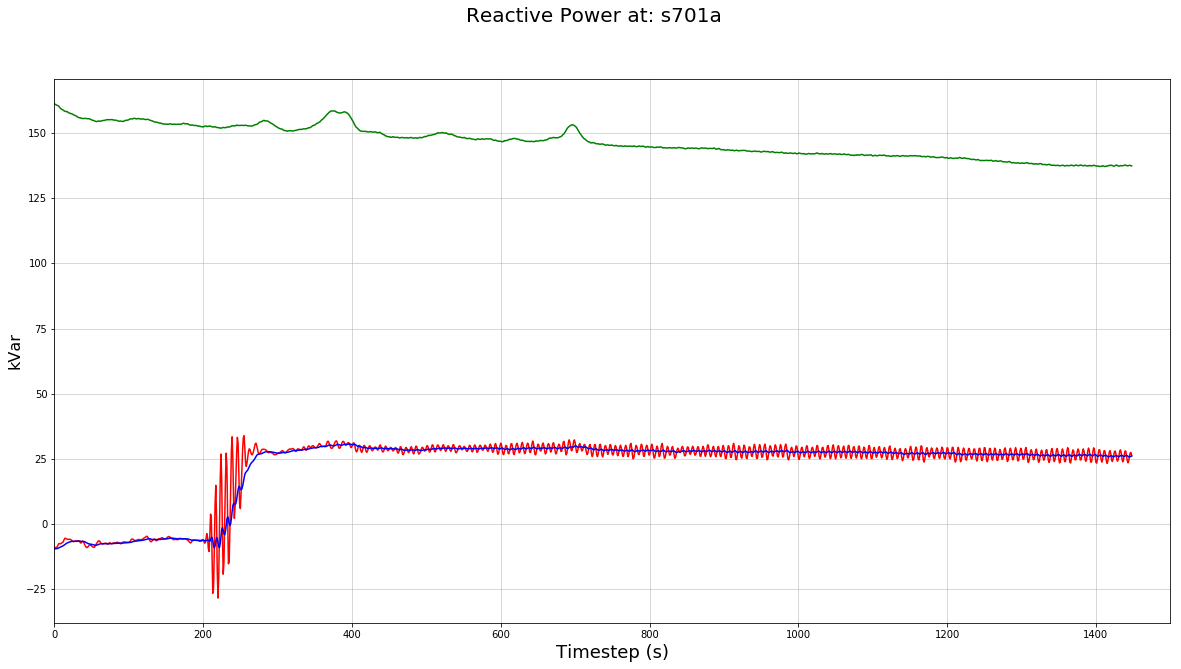

In [13]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
f.suptitle('Reactive Power at: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('kVar', fontsize=16)
key = 'inverter_s701a'
ax.plot(Logger.log_dict[key]['q_set'], 'r')
ax.plot(Logger.log_dict[key]['q_out'], 'b')
ax.plot(Logger.log_dict[key]['q_bar'], 'g')
plt.show()

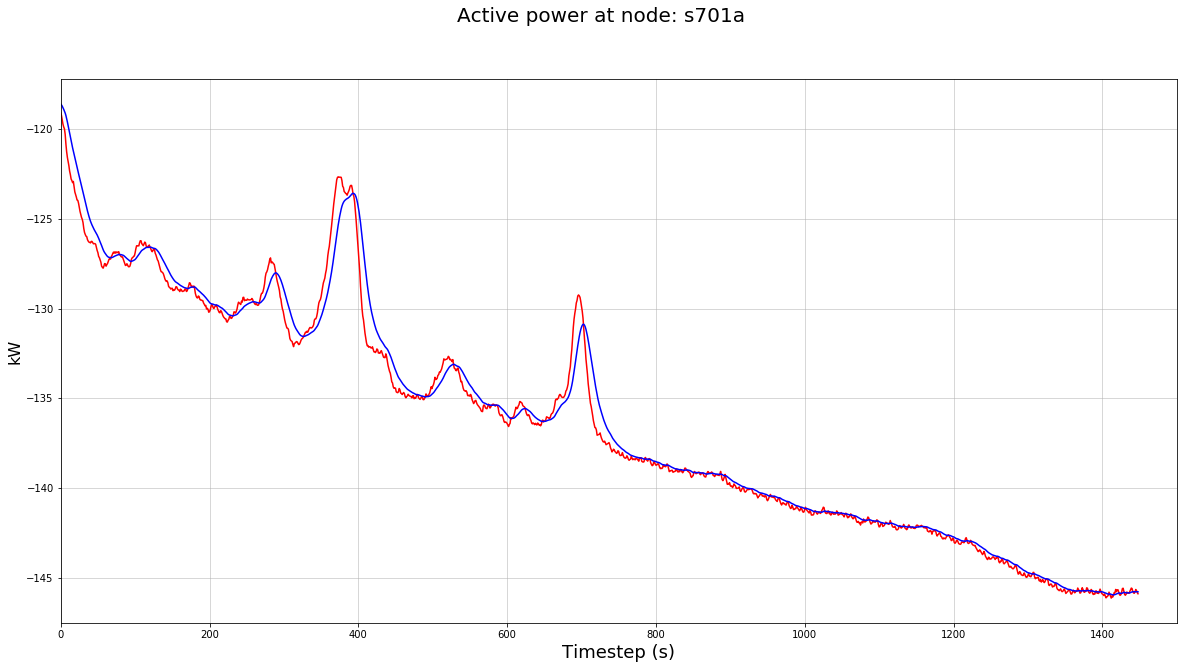

In [14]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
f.suptitle('Active power at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('kW', fontsize=16)
key = 'inverter_s701a'
ax.plot(Logger.log_dict[key]['p_set'], 'r')
ax.plot(Logger.log_dict[key]['p_out'], 'b')
plt.show()

In [15]:
list(Logger.log_dict['inverter_s701a'])

['y',
 'voltage_state',
 'q_bar',
 'u',
 'p_set',
 'q_set',
 'p_out',
 'q_out',
 'control_setting',
 'sbar_solarirr',
 'sbar_pset',
 'solar_irr',
 'node']